# Basic Pipeline

2025-07-22

In [1]:
library(Seurat)
library(harmony)
library(ggplot2)
set.seed(42) # for reproducibility

save_path = "basic_pipeline"

if (!dir.exists(save_path)) {
  dir.create(save_path, recursive = TRUE)
}

Warning message:
“package ‘Seurat’ was built under R version 4.3.2”


Loading required package: SeuratObject



Loading required package: sp



Warning message:
“package ‘sp’ was built under R version 4.3.3”



Attaching package: ‘SeuratObject’




The following object is masked from ‘package:base’:

    intersect




Warning message:
“package ‘harmony’ was built under R version 4.3.3”


Loading required package: Rcpp



Warning message:
“package ‘Rcpp’ was built under R version 4.3.3”


Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”


## Load data

The data used in this example is from the paper [Sikkema, L. et al. (2023)](https://doi.org/10.1038/s41591-023-02327-2).
This data can be accessed through this [collection](https://cellxgene.cziscience.com/collections/6f6d381a-7701-4781-935c-db10d30de293) on the Cellxgene platform. 
In this example however, we will use the sampled version of this data. 
Therefore, we set `min.cells` and `min.features` to 0, avoiding any further filtering.

In [2]:
count_matrix <- read.csv("/BiO/data/process/basic_pipeline_data/HLCA_pulmonary_fibrosis_immune_raw.csv", row.names = 1)
meta.data <- read.csv("/BiO/data/process/basic_pipeline_data/HLCA_pulmonary_fibrosis_immune_meta.csv", row.names = 1)

# so stands for 's'eurat 'o'bject 
so <- CreateSeuratObject(counts = count_matrix, meta.data = meta.data, assay = "RNA", min.cells = 0, min.features = 0, project = "HLCA_Pulmonary_Fibrosis_immune")
# genes are in rows, cells are in columns



Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


In [3]:
head(so, n = 3)

,orig.ident,nCount_RNA,nFeature_RNA,disease,study
,<fct>,<dbl>,<int>,<chr>,<chr>
F01173_GCTGGGTTCCTGTAGA_haberman,HLCA_Pulmonary_Fibrosis_immune,5525,1877,pulmonary fibrosis,Banovich_Kropski_2020
F00431_CTAGAGTCATGCCACG_haberman,HLCA_Pulmonary_Fibrosis_immune,2784,1017,pulmonary fibrosis,Banovich_Kropski_2020
F01172_AGTAGTCGTCCGACGT_haberman,HLCA_Pulmonary_Fibrosis_immune,1617,1012,pulmonary fibrosis,Banovich_Kropski_2020


## Normalization

### Seurat style

In seurat, we can perform normalization like below.

In [4]:
so <- NormalizeData(so)

Normalizing layer: counts



### Scran style

In scran, we first convert the object to a `SingleCellExperiment` object and perform normalization by:

1. clustering cells using `quickCluster()`
2. calculating cell-specific size factors using `computeSumFactors()`
3. dividing counts of each cell by its size factor, and log2-transforming with a pseudocount of 1 using `logNormCounts()`

Then, we convert the `SingleCellExperiment` object back to a `Seurat` object.

```r
library(scran)
library(scater)

sce <- as.SingleCellExperiment(so)

clusters <- quickCluster(sce)
sce <- computeSumFactors(sce, clusters = clusters)
sce.norm <- logNormCounts(sce,  pseudo_count = 1)
so <- as.Seurat(sce.norm, counts = "counts", data = "logcounts")
```

## Batch-aware feature selection

Selecting highly variable genes (HVGs) as a feature set is a common practice in single-cell RNA-seq analysis.
However, this data consists of samples across multiple studies, potentially introducing batch effects.
This kind of across-study batch effect can mask the real biological signal of interest.
To address this, we must take the batch information into account when selecting HVGs.

Here, we'll leverage this batch-aware feature implemented in a python package `scanpy`.

In [5]:
table(so$study)


 Banovich_Kropski_2020          Kaminski_2020 Misharin_Budinger_2018 
                  2338                   2328                    810 
         Sheppard_2020 
                  2306 

In [6]:
source("/BiO/data/batch_aware_in_seurat.R")

Loading required package: reticulate



Warning message:
“package ‘reticulate’ was built under R version 4.3.3”


In [7]:
batch_key <- "study"
nHVG <- 2000
batch_aware_in_seurat(so, batch_key = batch_key, nHVG = nHVG, conda_env = "/BiO/prog/miniforge3/envs/QC", save_path = save_path)
HVG <- read.csv(paste0(save_path, "/hvg_", nHVG, "_", batch_key, ".csv"))

head(HVG)

Warning message:
“No layers found matching search pattern provided”


Warning message:
“No layers found matching search pattern provided”


Warning message:
“Layer ‘scale.data’ is empty”


Warning message:
“Assay RNA changing from Assay5 to Assay”


,gene
,<chr>
1,A2M
2,ABAT
3,ABCA1
4,ABCA2
5,ABCB1
6,ABCC4


## Dimensionality Reduction

Based on the HVGs selected in the previous step, we can perform dimensionality reduction using PCA.

In [8]:
all.genes <- rownames(so)
so <- ScaleData(so, features = all.genes)

so <- RunPCA(so, features = HVG$gene)

Centering and scaling data matrix



PC_ 1 
Positive:  CST3, PSAP, CTSB, PLAUR, LYZ, C5AR1, S100A9, LST1, OLR1, CTSL 
	   CTSZ, CD14, TIMP1, MS4A7, MRC1.MRC1L1, CFD, CD163, MNDA, C1QA, MARCO 
	   VSIG4, LGALS3, MS4A6A, ETS2, CSTB, C1QB, NAMPT, S100A8, FBP1, SOD2.1.SOD2.1.SOD2.LOC100129518 
Negative:  CD69, CD247, IL32, CST7, NKG7, GZMA, GZMB, SYNE2, PRF1, CD7 
	   SKAP1, FYN, GNG2, KLRD1, CD3E, CD2, GNLY, CD96, CTSW, ETS1 
	   ITK, PARP8, SYTL3, LCK, GZMH, CD3D, PRKCH, SLC38A1, AC243829.1.CCL4, STAT4 
PC_ 2 
Positive:  BTG1, DDIT4, CTSD, TUBA1B, HSP90AA1, SFTPC, CCL3, DNAJB1, CTSW, MS4A7 
	   DUSP2, NKG7, GZMA, GIMAP7, LAT, CST7, CHMP1B, FKBP11, AC243829.1.CCL4, IL32 
	   LYZ, CD3E, HOPX, GNLY, SH2D1A, GZMB, CD69, CD7, TRAF3IP3, GZMM 
Negative:  SIPA1L1, ELL2, DENND4A, FOXO1, KDM6A, MT.ND4L, PITPNC1, SLC16A10, DENND5A, MGAT5 
	   FMN1, NBPF19, KIF13B, FNDC3A, SH3PXD2B, B4GALT1, SPAG9, RGPD5, XYLT1, ATP13A3 
	   PELI1, AC006978.2.GS1.114I9.3.ZNRF2.ENSG00000281593, SLC8A1, CTNNB1, SMYD3, USP36, NFKB1, AKT3, SYTL3, ABCA1 
PC

In [9]:
options(repr.plot.width = 4, repr.plot.height = 4)

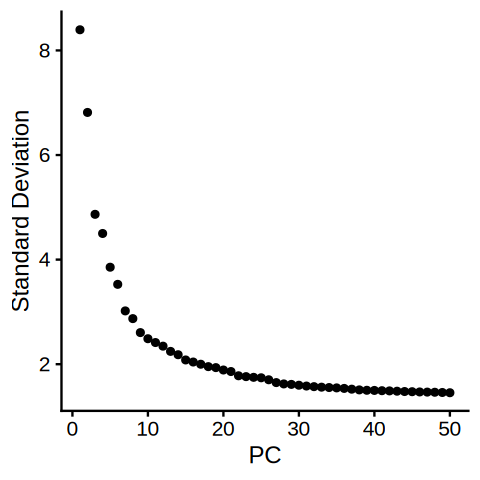

In [10]:
ElbowPlot(so, ndims = 50)

In [11]:
PCs <- 8

so <- FindNeighbors(so, dims = 1:PCs)
so <- FindClusters(so, resolution = 0.5)

so <- RunUMAP(so, dims = 1:PCs)
# so <- RunTSNE(so, dims = 1:PCs)

Computing nearest neighbor graph



Warning message:
“package ‘future’ was built under R version 4.3.3”


Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7782
Number of edges: 252571

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9204
Number of communities: 12
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


22:49:04 UMAP embedding parameters a = 0.9922 b = 1.112



22:49:04 Read 7782 rows and found 8 numeric columns



22:49:04 Using Annoy for neighbor search, n_neighbors = 30



22:49:04 Building Annoy index with metric = cosine, n_trees = 50



0%   10   20   30   40   50   60   70   80   90   100%



[----|----|----|----|----|----|----|----|----|----|



*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


|



22:49:04 Writing NN index file to temp file /tmp/Rtmp11dhFX/file1073685f404613



22:49:04 Searching Annoy index using 1 thread, search_k = 3000



22:49:06 Annoy recall = 100%



22:49:07 Commencing smooth kNN distance calibration using 1 thread


 with target n_neighbors = 30



22:49:07 Initializing from normalized Laplacian + noise (using RSpectra)



22:49:07 Commencing optimization for 500 epochs, with 307036 positive edges



22:49:07 Using rng type: pcg



22:49:16 Optimization finished



In [12]:
options(repr.plot.width = 8, repr.plot.height = 6)

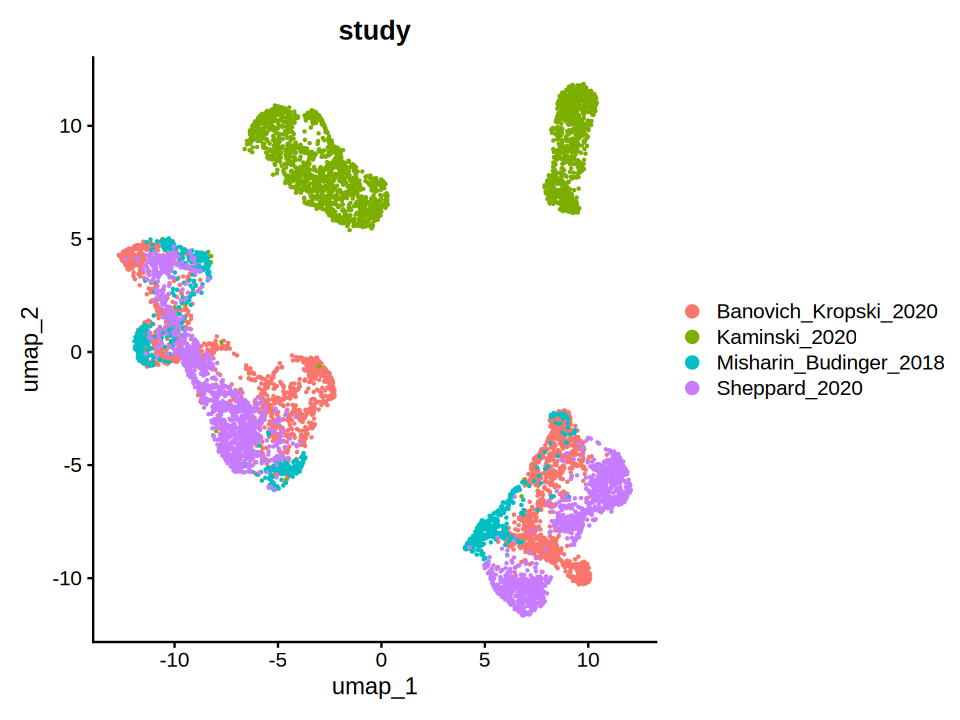

In [13]:
DimPlot(so, group.by = "study")

## Batch Correction by Harmony

We can correct the batch effects using the method from the paper [Korsunsky, I. et al. (2019)](https://doi.org/10.1038/s41592-019-0619-0).
You can find out more about this method in its [documentations](https://portals.broadinstitute.org/harmony/articles/quickstart.html).

In [14]:
so <- RunHarmony(so, "study")
so <- FindNeighbors(so, reduction = "harmony")
so <- FindClusters(so, resolution = 0.5) 
so <- RunUMAP(so, dims = 1:PCs, reduction = "harmony", reduction.name = "umap.harmony") # use same dimension number as before
# so <- RunTSNE(so, dims = 1:PCs, reduction = "harmony", reduction.name = "tsne.harmony")

Transposing data matrix



Initializing state using k-means centroids initialization



Harmony 1/10



Harmony 2/10



Harmony 3/10



Harmony 4/10



Harmony 5/10



Harmony converged after 5 iterations



Computing nearest neighbor graph



Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7782
Number of edges: 268158

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8761
Number of communities: 9
Elapsed time: 0 seconds


22:49:23 UMAP embedding parameters a = 0.9922 b = 1.112



22:49:23 Read 7782 rows and found 8 numeric columns



22:49:23 Using Annoy for neighbor search, n_neighbors = 30



22:49:23 Building Annoy index with metric = cosine, n_trees = 50



0%   10   20   30   40   50   60   70   80   90   100%



[----|----|----|----|----|----|----|----|----|----|



*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


|



22:49:23 Writing NN index file to temp file /tmp/Rtmp11dhFX/file107368721d21ff



22:49:23 Searching Annoy index using 1 thread, search_k = 3000



22:49:25 Annoy recall = 100%



22:49:26 Commencing smooth kNN distance calibration using 1 thread


 with target n_neighbors = 30



22:49:26 Initializing from normalized Laplacian + noise (using RSpectra)



22:49:26 Commencing optimization for 500 epochs, with 316290 positive edges



22:49:26 Using rng type: pcg



22:49:35 Optimization finished



In [15]:
options(repr.plot.width = 8, repr.plot.height = 6)

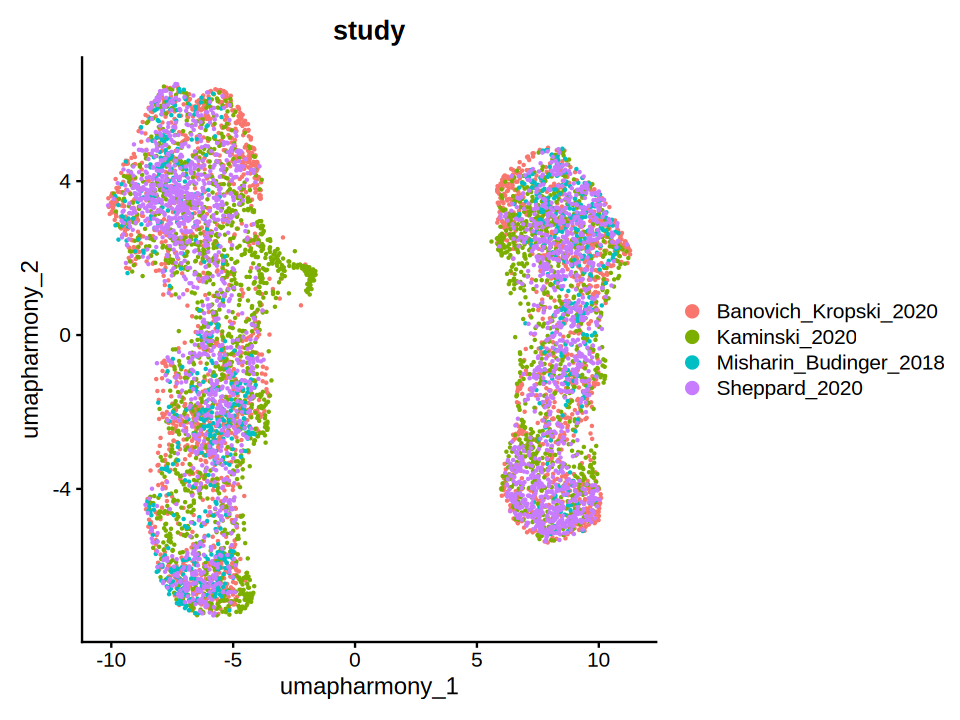

In [16]:
DimPlot(so, group.by = "study", reduction = "umap.harmony")

In [17]:
options(repr.plot.width = 8, repr.plot.height = 6)

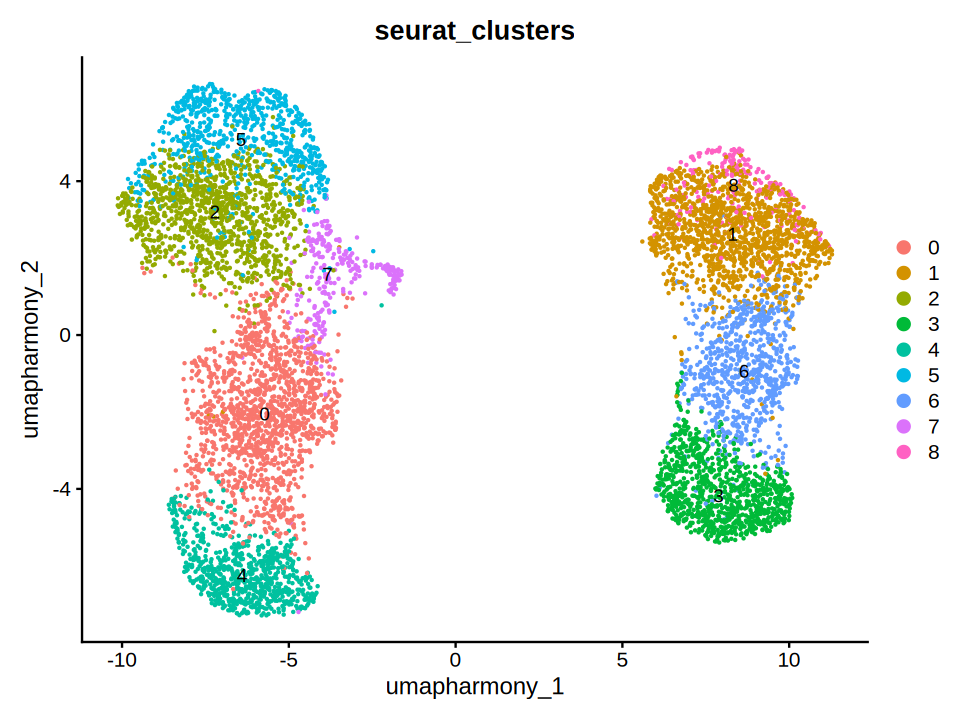

In [18]:
DimPlot(so, group.by = "seurat_clusters", reduction = "umap.harmony", label = TRUE)

## Automatic cell type annotation with CellTypist

Traditionally, cell type annotation is done manually by inspecting marker genes by a human expert.
As this process is time and labor intensive, we can use a machine learning based approach to automate this process.

In [19]:
source("/BiO/data/celltypist_in_seurat.R")
celltypist_in_seurat(so, conda_env = "/BiO/prog/miniforge3/envs/QC", save_path = save_path, model_path = "/BiO/data/Immune_All_High.pkl")

Warning message:
“Assay RNA changing from Assay5 to Assay”


## Visualize marker gene expression

In [20]:
options(repr.plot.width = 13, repr.plot.height = 9)

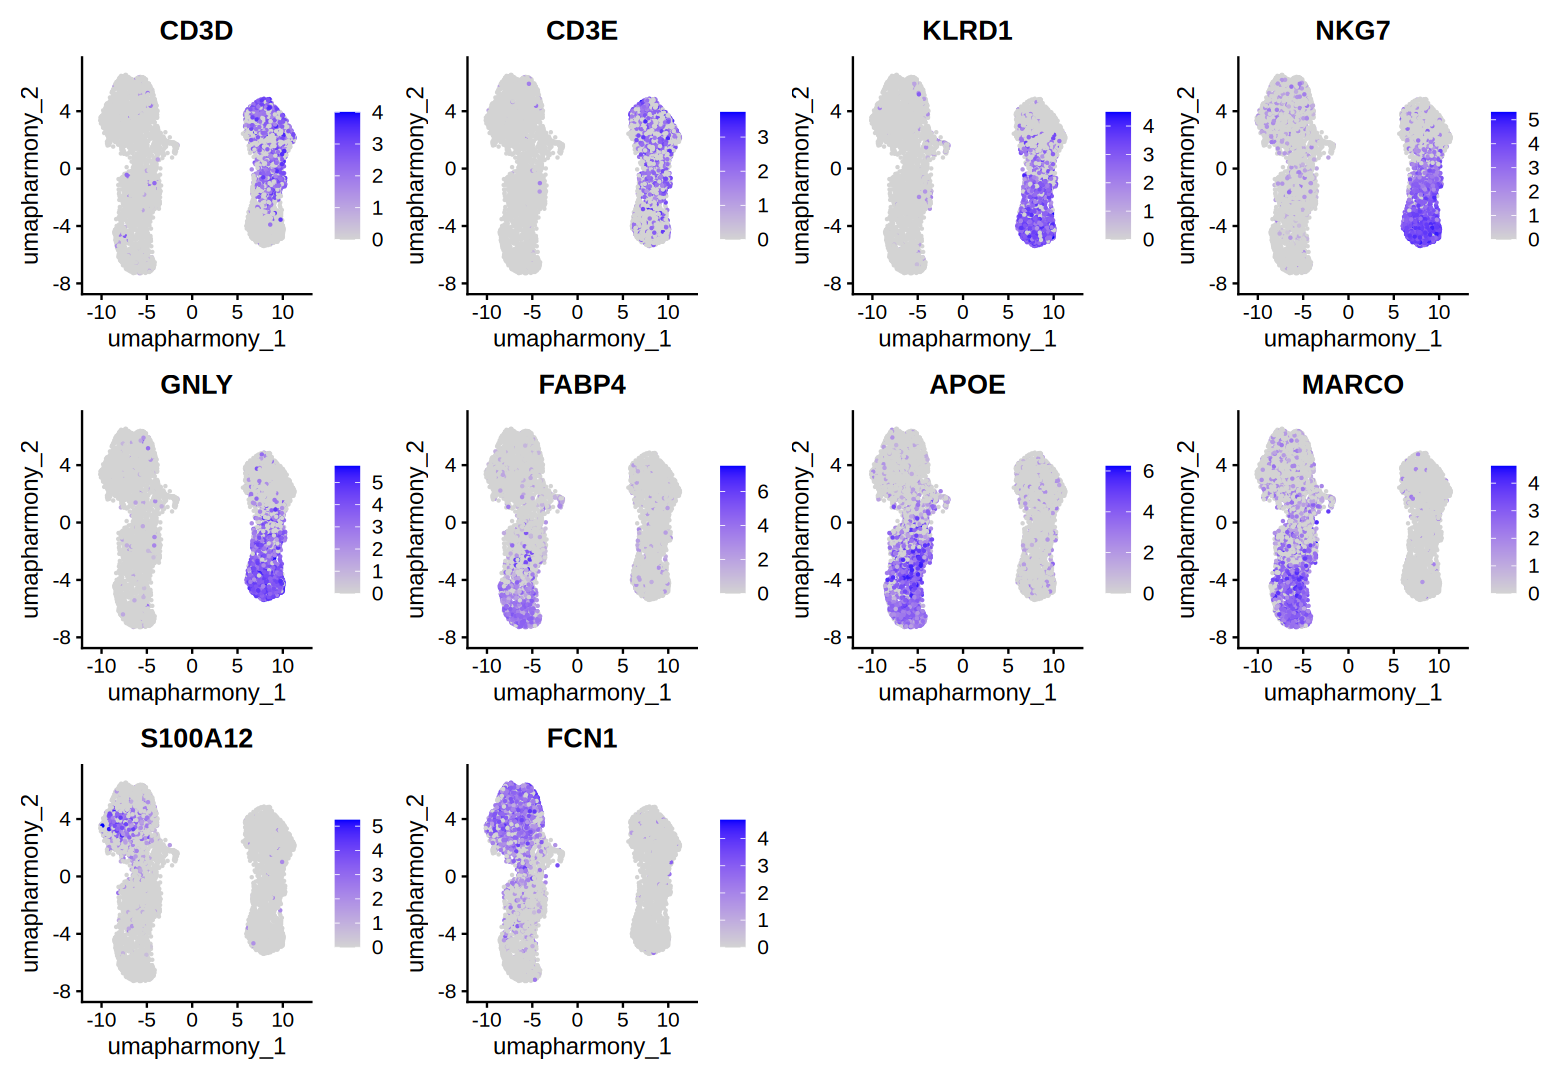

In [21]:
marker.genes <- list(
    T.cell = c("CD3D", "CD3E"),
    NK.cell = c("KLRD1", "NKG7", "GNLY"),
    Macrophage = c("FABP4", "APOE", "MARCO"),
    Monocyte = c("S100A12", "FCN1")
)

FeaturePlot(so, features = as.vector(unlist(marker.genes)), ncol = 4, reduction = "umap.harmony")

In [22]:
options(repr.plot.width = 14, repr.plot.height = 8)

Warning message:
“The `facets` argument of `facet_grid()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `rows` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


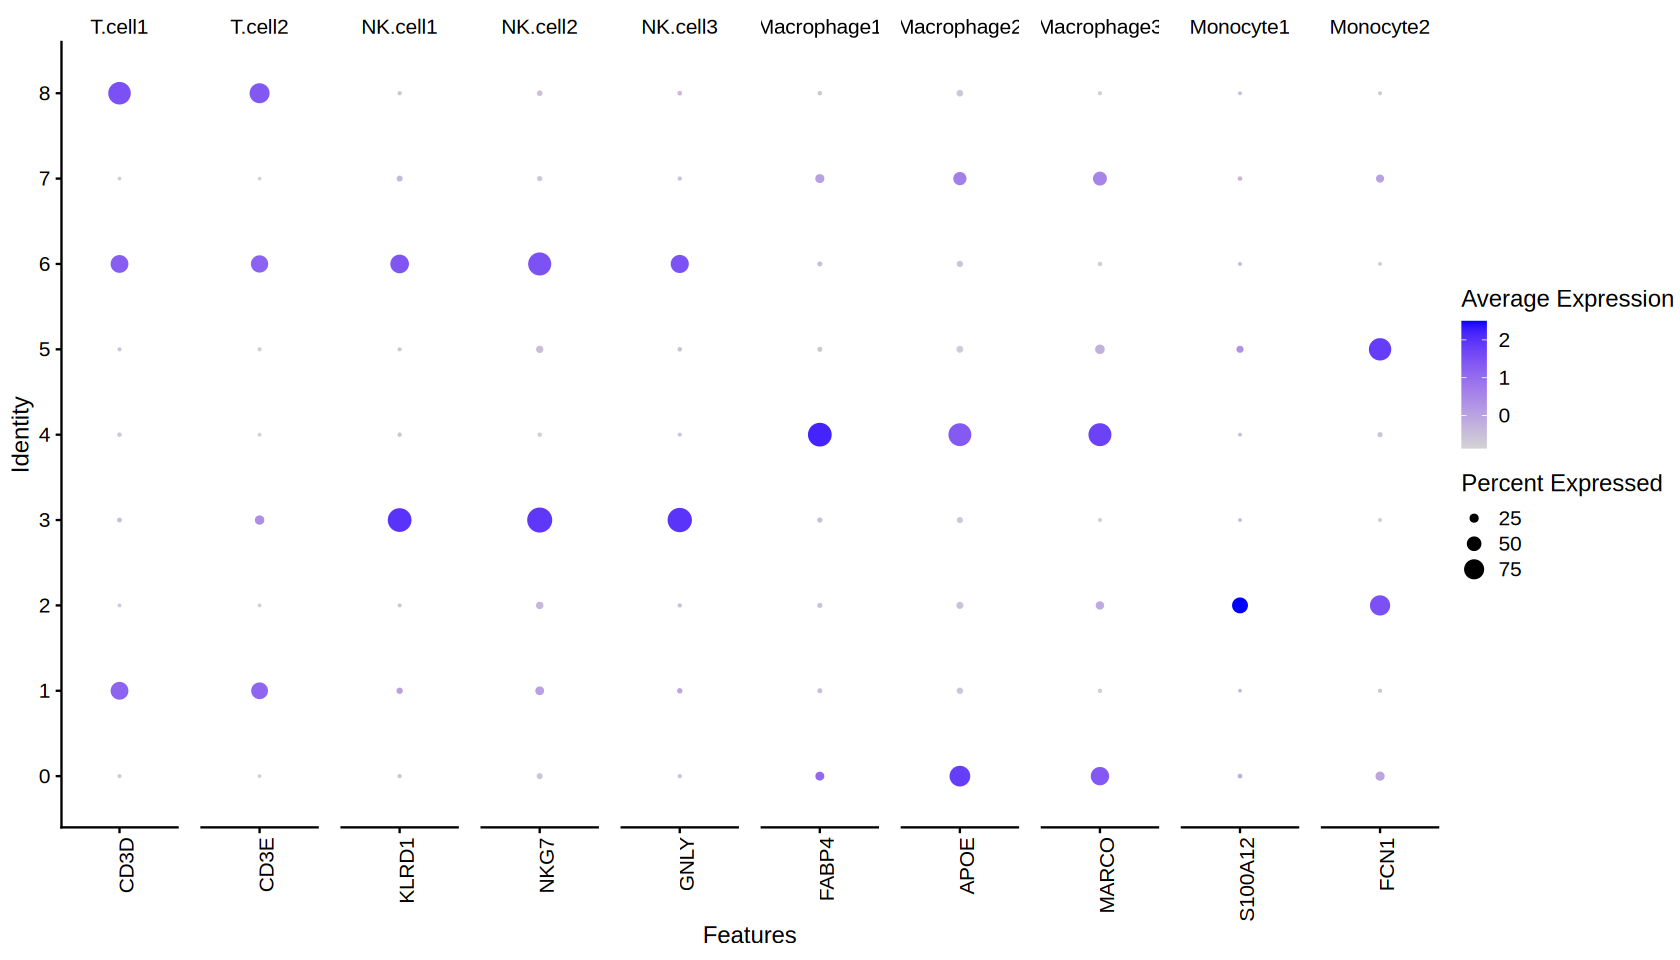

In [23]:
DotPlot(so, features = unlist(marker.genes), group.by = "seurat_clusters") +
    theme(axis.text.x = element_text(angle = 90))

In [24]:
options(repr.plot.width = 8, repr.plot.height = 6)

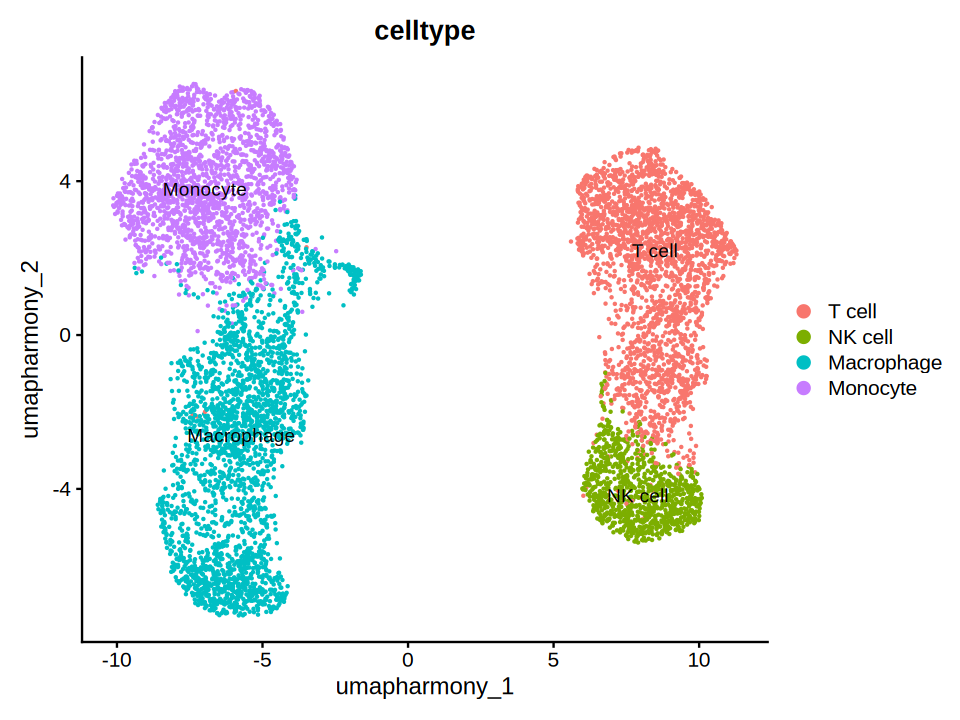

In [25]:
so$celltype <- as.character(so$seurat_clusters)
so$celltype[so$celltype %in% c(1, 6, 8)] <- "T cell"
so$celltype[so$celltype %in% c(3)] <- "NK cell"
so$celltype[so$celltype %in% c(0, 4, 7)] <- "Macrophage"
so$celltype[so$celltype %in% c(2, 5)] <- "Monocyte"
so$celltype = factor(so$celltype, levels = c("T cell", "NK cell", "Macrophage", "Monocyte"))

DimPlot(so, group.by = "celltype", reduction = "umap.harmony", label = TRUE)

In [26]:
options(repr.plot.width = 10, repr.plot.height = 6)

Warning message:
“Scaling data with a low number of groups may produce misleading results”


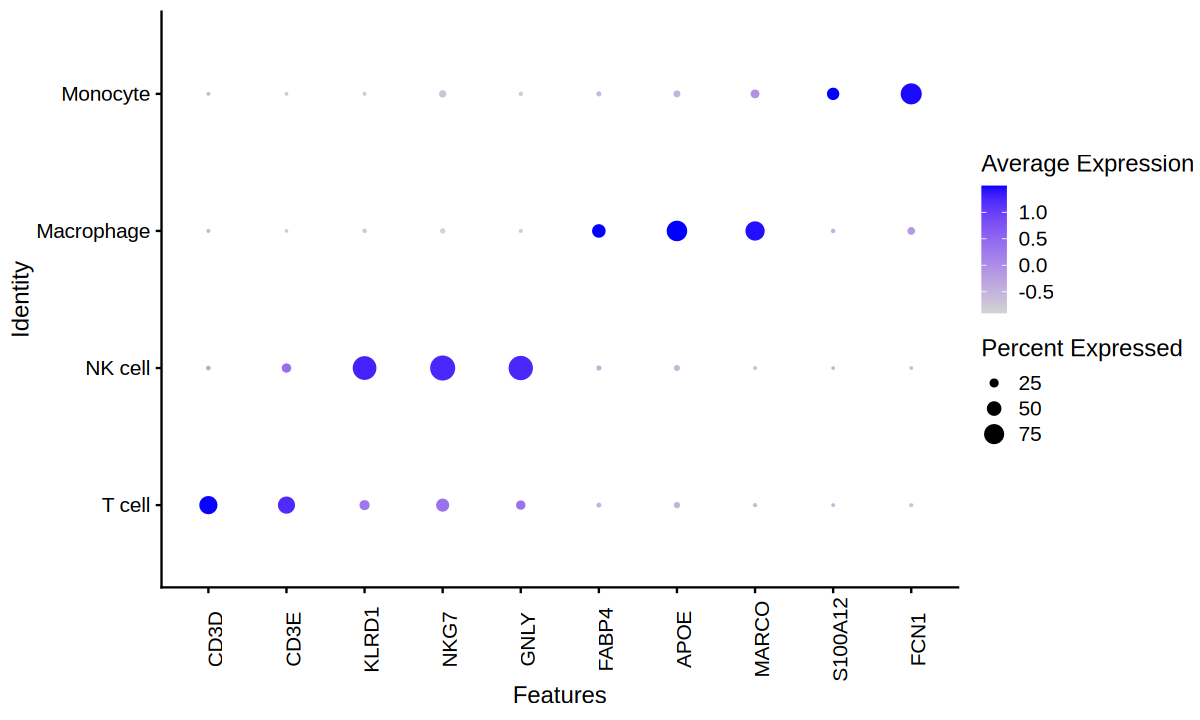

In [27]:
DotPlot(so, features = as.vector(unlist(marker.genes)), group.by = "celltype") +
    theme(axis.text.x = element_text(angle = 90))

## Selecting patient-aware differentially expressed genes (DEGs)

In [28]:
donor_id <- read.csv("/BiO/data/HLCA_pulmonary_fibrosis_donor_subset.csv", row.names = 1)
so$donor.id <- donor_id[Cells(so), ]

In [29]:
library(EnhancedVolcano)

Tcells.control <- Cells(so)[so$celltype == "T cell" & so$disease == "normal"]
Tcells.pulmonary <- Cells(so)[so$celltype == "T cell" & so$disease == "pulmonary fibrosis"]

DEG.vanilla <- FindMarkers(so, ident.1 = Tcells.pulmonary, ident.2 = Tcells.control)
DEG.patient.correction <- FindMarkers(so, ident.1 = Tcells.pulmonary, ident.2 = Tcells.control, test.use = "MAST", latent.vars = "donor.id")

Warning message:
“package ‘EnhancedVolcano’ was built under R version 4.3.2”


Loading required package: ggrepel



Warning message:
“package ‘ggrepel’ was built under R version 4.3.3”


Warning message in .nextMethod(object = object, value = value):
“Coefficients donor.idhomosapiens_None_2023_None_sikkemalisa_002_d10_1101_2022_03_10_483747VUILD65 are never estimible and will be dropped.”


 Completed [--------------------------------------------]   0% with 0 failures


 Completed [--------------------------------------------]   1% with 0 failures


 Completed [>-------------------------------------------]   1% with 0 failures


 Completed [>-------------------------------------------]   2% with 0 failures


 Completed [>-------------------------------------------]   3% with 0 failures


 Completed [=>------------------------------------------]   3% with 0 failures


 Completed [=>------------------------------------------]   4% with 0 failures


 Completed [=>------------------------------------------]   5% with 0 failures


 Completed [=>------------------------------------------]   6% with 0 failures


 Completed [==>-----------------------------------------]   6% with 0 failures


 Completed [==>-----------------------------------------]   7% with 0 failures


 Completed [==>-----------------------------------------]   8% with 0 failures


 Completed [===>----------------------------------------]   8% with 0 failures


 Completed [===>----------------------------------------]   9% with 0 failures


 Completed [===>----------------------------------------]  10% with 0 failures


 Completed [====>---------------------------------------]  10% with 0 failures


 Completed [====>---------------------------------------]  11% with 0 failures


 Completed [====>---------------------------------------]  12% with 0 failures


 Completed [=====>--------------------------------------]  13% with 0 failures


 Completed [=====>--------------------------------------]  14% with 0 failures


 Completed [=====>--------------------------------------]  15% with 0 failures


 Completed [======>-------------------------------------]  15% with 0 failures


 Completed [======>-------------------------------------]  16% with 0 failures


 Completed [======>-------------------------------------]  17% with 0 failures


 Completed [=======>------------------------------------]  17% with 0 failures


 Completed [=======>------------------------------------]  18% with 0 failures


 Completed [=======>------------------------------------]  19% with 0 failures


 Completed [========>-----------------------------------]  19% with 0 failures


 Completed [========>-----------------------------------]  20% with 0 failures


 Completed [========>-----------------------------------]  21% with 0 failures


 Completed [========>-----------------------------------]  22% with 0 failures


 Completed [=========>----------------------------------]  22% with 0 failures


 Completed [=========>----------------------------------]  23% with 0 failures


 Completed [=========>----------------------------------]  24% with 0 failures


 Completed [==========>---------------------------------]  24% with 0 failures


 Completed [==========>---------------------------------]  25% with 0 failures


 Completed [==========>---------------------------------]  26% with 0 failures


 Completed [===========>--------------------------------]  26% with 0 failures


 Completed [===========>--------------------------------]  27% with 0 failures


 Completed [===========>--------------------------------]  28% with 0 failures


 Completed [============>-------------------------------]  28% with 0 failures


 Completed [============>-------------------------------]  29% with 0 failures


 Completed [============>-------------------------------]  30% with 0 failures


 Completed [============>-------------------------------]  31% with 0 failures


 Completed [=============>------------------------------]  31% with 0 failures


 Completed [=============>------------------------------]  32% with 0 failures


 Completed [=============>------------------------------]  33% with 0 failures


 Completed [==============>-----------------------------]  33% with 0 failures


 Completed [==============>-----------------------------]  34% with 0 failures


 Completed [==============>-----------------------------]  35% with 0 failures


 Completed [===============>----------------------------]  35% with 0 failures


 Completed [===============>----------------------------]  36% with 0 failures


 Completed [===============>----------------------------]  37% with 0 failures


 Completed [================>---------------------------]  38% with 0 failures


 Completed [================>---------------------------]  39% with 0 failures


 Completed [================>---------------------------]  40% with 0 failures


 Completed [=================>--------------------------]  40% with 0 failures


 Completed [=================>--------------------------]  41% with 0 failures


 Completed [=================>--------------------------]  42% with 0 failures


 Completed [==================>-------------------------]  42% with 0 failures


 Completed [==================>-------------------------]  43% with 0 failures


 Completed [==================>-------------------------]  44% with 0 failures


 Completed [===================>------------------------]  44% with 0 failures


 Completed [===================>------------------------]  45% with 0 failures


 Completed [===================>------------------------]  46% with 0 failures


 Completed [===================>------------------------]  47% with 0 failures


 Completed [====================>-----------------------]  47% with 0 failures


 Completed [====================>-----------------------]  48% with 0 failures


 Completed [====================>-----------------------]  49% with 0 failures


 Completed [=====================>----------------------]  49% with 0 failures


 Completed [=====================>----------------------]  50% with 0 failures


 Completed [=====================>----------------------]  51% with 0 failures


 Completed [======================>---------------------]  51% with 0 failures


 Completed [======================>---------------------]  52% with 0 failures


 Completed [======================>---------------------]  53% with 0 failures


 Completed [=======================>--------------------]  53% with 0 failures


 Completed [=======================>--------------------]  54% with 0 failures


 Completed [=======================>--------------------]  55% with 0 failures


 Completed [=======================>--------------------]  56% with 0 failures


 Completed [========================>-------------------]  56% with 0 failures


 Completed [========================>-------------------]  57% with 0 failures


 Completed [========================>-------------------]  58% with 0 failures


 Completed [=========================>------------------]  58% with 0 failures


 Completed [=========================>------------------]  59% with 0 failures


 Completed [=========================>------------------]  60% with 0 failures


 Completed [==========================>-----------------]  60% with 0 failures


 Completed [==========================>-----------------]  61% with 0 failures


 Completed [==========================>-----------------]  62% with 0 failures


 Completed [===========================>----------------]  63% with 0 failures


 Completed [===========================>----------------]  64% with 0 failures


 Completed [===========================>----------------]  65% with 0 failures


 Completed [============================>---------------]  65% with 0 failures


 Completed [============================>---------------]  66% with 0 failures


 Completed [============================>---------------]  67% with 0 failures


 Completed [=============================>--------------]  67% with 0 failures


 Completed [=============================>--------------]  68% with 0 failures


 Completed [=============================>--------------]  69% with 0 failures


 Completed [==============================>-------------]  69% with 0 failures


 Completed [==============================>-------------]  70% with 0 failures


 Completed [==============================>-------------]  71% with 0 failures


 Completed [==============================>-------------]  72% with 0 failures


 Completed [===============================>------------]  72% with 0 failures


 Completed [===============================>------------]  73% with 0 failures


 Completed [===============================>------------]  74% with 0 failures


 Completed [================================>-----------]  74% with 0 failures


 Completed [================================>-----------]  75% with 0 failures


 Completed [================================>-----------]  76% with 0 failures


 Completed [=================================>----------]  76% with 0 failures


 Completed [=================================>----------]  77% with 0 failures


 Completed [=================================>----------]  78% with 0 failures


 Completed [==================================>---------]  78% with 0 failures


 Completed [==================================>---------]  79% with 0 failures


 Completed [==================================>---------]  80% with 0 failures


 Completed [==================================>---------]  81% with 0 failures


 Completed [===================================>--------]  81% with 0 failures


 Completed [===================================>--------]  82% with 0 failures


 Completed [===================================>--------]  83% with 0 failures


 Completed [====================================>-------]  83% with 0 failures


 Completed [====================================>-------]  84% with 0 failures


 Completed [====================================>-------]  85% with 0 failures


 Completed [=====================================>------]  85% with 0 failures


 Completed [=====================================>------]  86% with 0 failures


 Completed [=====================================>------]  87% with 0 failures


 Completed [======================================>-----]  88% with 0 failures


 Completed [======================================>-----]  89% with 0 failures


 Completed [======================================>-----]  90% with 0 failures


 Completed [=======================================>----]  90% with 0 failures


 Completed [=======================================>----]  91% with 0 failures


 Completed [=======================================>----]  92% with 0 failures


 Completed [========================================>---]  92% with 0 failures


 Completed [========================================>---]  93% with 0 failures


 Completed [========================================>---]  94% with 0 failures


 Completed [=========================================>--]  94% with 0 failures


 Completed [=========================================>--]  95% with 0 failures


 Completed [=========================================>--]  96% with 0 failures


 Completed [=========================================>--]  97% with 0 failures


 Completed [==========================================>-]  97% with 0 failures


 Completed [==========================================>-]  98% with 0 failures


 Completed [==========================================>-]  99% with 0 failures


 Completed [===========================================>]  99% with 0 failures


 Completed [===========================================>] 100% with 0 failures


 Completed [============================================] 100% with 0 failures



Done!



Combining coefficients and standard errors



Calculating log-fold changes



Calculating likelihood ratio tests



Refitting on reduced model...



 Completed [--------------------------------------------]   0% with 0 failures


 Completed [--------------------------------------------]   1% with 0 failures


 Completed [>-------------------------------------------]   1% with 0 failures


 Completed [>-------------------------------------------]   2% with 0 failures


 Completed [>-------------------------------------------]   3% with 0 failures


 Completed [=>------------------------------------------]   3% with 0 failures


 Completed [=>------------------------------------------]   4% with 0 failures


 Completed [=>------------------------------------------]   5% with 0 failures


 Completed [=>------------------------------------------]   6% with 0 failures


 Completed [==>-----------------------------------------]   6% with 0 failures


 Completed [==>-----------------------------------------]   7% with 0 failures


 Completed [==>-----------------------------------------]   8% with 0 failures


 Completed [===>----------------------------------------]   8% with 0 failures


 Completed [===>----------------------------------------]   9% with 0 failures


 Completed [===>----------------------------------------]  10% with 0 failures


 Completed [====>---------------------------------------]  10% with 0 failures


 Completed [====>---------------------------------------]  11% with 0 failures


 Completed [====>---------------------------------------]  12% with 0 failures


 Completed [=====>--------------------------------------]  13% with 0 failures


 Completed [=====>--------------------------------------]  14% with 0 failures


 Completed [=====>--------------------------------------]  15% with 0 failures


 Completed [======>-------------------------------------]  15% with 0 failures


 Completed [======>-------------------------------------]  16% with 0 failures


 Completed [======>-------------------------------------]  17% with 0 failures


 Completed [=======>------------------------------------]  17% with 0 failures


 Completed [=======>------------------------------------]  18% with 0 failures


 Completed [=======>------------------------------------]  19% with 0 failures


 Completed [========>-----------------------------------]  19% with 0 failures


 Completed [========>-----------------------------------]  20% with 0 failures


 Completed [========>-----------------------------------]  21% with 0 failures


 Completed [========>-----------------------------------]  22% with 0 failures


 Completed [=========>----------------------------------]  22% with 0 failures


 Completed [=========>----------------------------------]  23% with 0 failures


 Completed [=========>----------------------------------]  24% with 0 failures


 Completed [==========>---------------------------------]  24% with 0 failures


 Completed [==========>---------------------------------]  25% with 0 failures


 Completed [==========>---------------------------------]  26% with 0 failures


 Completed [===========>--------------------------------]  26% with 0 failures


 Completed [===========>--------------------------------]  27% with 0 failures


 Completed [===========>--------------------------------]  28% with 0 failures


 Completed [============>-------------------------------]  28% with 0 failures


 Completed [============>-------------------------------]  29% with 0 failures


 Completed [============>-------------------------------]  30% with 0 failures


 Completed [============>-------------------------------]  31% with 0 failures


 Completed [=============>------------------------------]  31% with 0 failures


 Completed [=============>------------------------------]  32% with 0 failures


 Completed [=============>------------------------------]  33% with 0 failures


 Completed [==============>-----------------------------]  33% with 0 failures


 Completed [==============>-----------------------------]  34% with 0 failures


 Completed [==============>-----------------------------]  35% with 0 failures


 Completed [===============>----------------------------]  35% with 0 failures


 Completed [===============>----------------------------]  36% with 0 failures


 Completed [===============>----------------------------]  37% with 0 failures


 Completed [================>---------------------------]  38% with 0 failures


 Completed [================>---------------------------]  39% with 0 failures


 Completed [================>---------------------------]  40% with 0 failures


 Completed [=================>--------------------------]  40% with 0 failures


 Completed [=================>--------------------------]  41% with 0 failures


 Completed [=================>--------------------------]  42% with 0 failures


 Completed [==================>-------------------------]  42% with 0 failures


 Completed [==================>-------------------------]  43% with 0 failures


 Completed [==================>-------------------------]  44% with 0 failures


 Completed [===================>------------------------]  44% with 0 failures


 Completed [===================>------------------------]  45% with 0 failures


 Completed [===================>------------------------]  46% with 0 failures


 Completed [===================>------------------------]  47% with 0 failures


 Completed [====================>-----------------------]  47% with 0 failures


 Completed [====================>-----------------------]  48% with 0 failures


 Completed [====================>-----------------------]  49% with 0 failures


 Completed [=====================>----------------------]  49% with 0 failures


 Completed [=====================>----------------------]  50% with 0 failures


 Completed [=====================>----------------------]  51% with 0 failures


 Completed [======================>---------------------]  51% with 0 failures


 Completed [======================>---------------------]  52% with 0 failures


 Completed [======================>---------------------]  53% with 0 failures


 Completed [=======================>--------------------]  53% with 0 failures


 Completed [=======================>--------------------]  54% with 0 failures


 Completed [=======================>--------------------]  55% with 0 failures


 Completed [=======================>--------------------]  56% with 0 failures


 Completed [========================>-------------------]  56% with 0 failures


 Completed [========================>-------------------]  57% with 0 failures


 Completed [========================>-------------------]  58% with 0 failures


 Completed [=========================>------------------]  58% with 0 failures


 Completed [=========================>------------------]  59% with 0 failures


 Completed [=========================>------------------]  60% with 0 failures


 Completed [==========================>-----------------]  60% with 0 failures


 Completed [==========================>-----------------]  61% with 0 failures


 Completed [==========================>-----------------]  62% with 0 failures


 Completed [===========================>----------------]  63% with 0 failures


 Completed [===========================>----------------]  64% with 0 failures


 Completed [===========================>----------------]  65% with 0 failures


 Completed [============================>---------------]  65% with 0 failures


 Completed [============================>---------------]  66% with 0 failures


 Completed [============================>---------------]  67% with 0 failures


 Completed [=============================>--------------]  67% with 0 failures


 Completed [=============================>--------------]  68% with 0 failures


 Completed [=============================>--------------]  69% with 0 failures


 Completed [==============================>-------------]  69% with 0 failures


 Completed [==============================>-------------]  70% with 0 failures


 Completed [==============================>-------------]  71% with 0 failures


 Completed [==============================>-------------]  72% with 0 failures


 Completed [===============================>------------]  72% with 0 failures


 Completed [===============================>------------]  73% with 0 failures


 Completed [===============================>------------]  74% with 0 failures


 Completed [================================>-----------]  74% with 0 failures


 Completed [================================>-----------]  75% with 0 failures


 Completed [================================>-----------]  76% with 0 failures


 Completed [=================================>----------]  76% with 0 failures


 Completed [=================================>----------]  77% with 0 failures


 Completed [=================================>----------]  78% with 0 failures


 Completed [==================================>---------]  78% with 0 failures


 Completed [==================================>---------]  79% with 0 failures


 Completed [==================================>---------]  80% with 0 failures


 Completed [==================================>---------]  81% with 0 failures


 Completed [===================================>--------]  81% with 0 failures


 Completed [===================================>--------]  82% with 0 failures


 Completed [===================================>--------]  83% with 0 failures


 Completed [====================================>-------]  83% with 0 failures


 Completed [====================================>-------]  84% with 0 failures


 Completed [====================================>-------]  85% with 0 failures


 Completed [=====================================>------]  85% with 0 failures


 Completed [=====================================>------]  86% with 0 failures


 Completed [=====================================>------]  87% with 0 failures


 Completed [======================================>-----]  88% with 0 failures


 Completed [======================================>-----]  89% with 0 failures


 Completed [======================================>-----]  90% with 0 failures


 Completed [=======================================>----]  90% with 0 failures


 Completed [=======================================>----]  91% with 0 failures


 Completed [=======================================>----]  92% with 0 failures


 Completed [========================================>---]  92% with 0 failures


 Completed [========================================>---]  93% with 0 failures


 Completed [========================================>---]  94% with 0 failures


 Completed [=========================================>--]  94% with 0 failures


 Completed [=========================================>--]  95% with 0 failures


 Completed [=========================================>--]  96% with 0 failures


 Completed [=========================================>--]  97% with 0 failures


 Completed [==========================================>-]  97% with 0 failures


 Completed [==========================================>-]  98% with 0 failures


 Completed [==========================================>-]  99% with 0 failures


 Completed [===========================================>]  99% with 0 failures


 Completed [===========================================>] 100% with 0 failures


 Completed [============================================] 100% with 0 failures



Done!



In [30]:
options(repr.plot.width = 8, repr.plot.height = 6)

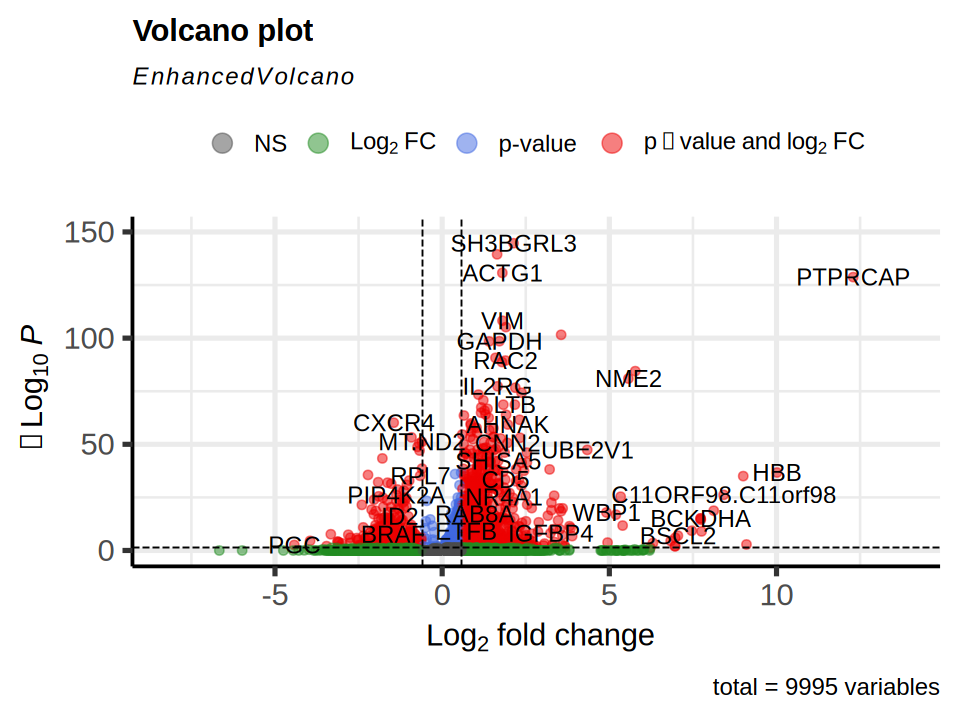

In [31]:
EnhancedVolcano(DEG.vanilla, lab = rownames(DEG.vanilla), x = "avg_log2FC", y = "p_val_adj", FCcutoff = log2(1.5), pCutoff = 0.05)

In [32]:
options(repr.plot.width = 8, repr.plot.height = 6)

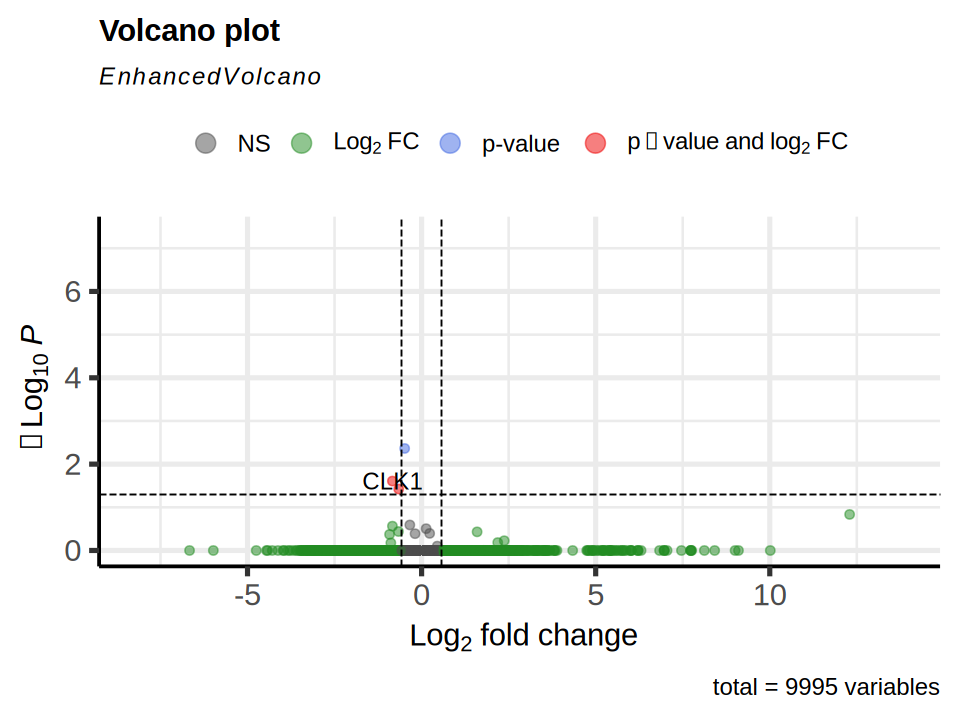

In [33]:
EnhancedVolcano(DEG.patient.correction, lab = rownames(DEG.patient.correction), x = "avg_log2FC", y = "p_val_adj", FCcutoff = log2(1.5), pCutoff = 0.05)

In [34]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 24.04.2 LTS

Matrix products: default
BLAS/LAPACK: /BiO/prog/miniforge3/envs/QC/lib/libopenblasp-r0.3.30.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Seoul
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] EnhancedVolcano_1.20.0 ggrepel_0.9.6          future_1.58.0         
 [4] sceasy_0.0.7           reticulate_1.42.0      ggplot2_3.5.2         
 [7] harmony_1.2.3          Rcpp_1.1.0             Seurat_5.0.1          
[10] SeuratO